In [1]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import scipy as sp
import scipy.stats
import pandas as pd
import numpy as np
from tqdm import tqdm
import itertools
import re
res_digit = r'[0-9]'

# fourier transform
from scipy.fft import fft, ifft

from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.manifold import TSNE



In [2]:
# This is a hack to make the library in the parent folder available for imoprts
# A better solution is by np8 here:
# https://stackoverflow.com/questions/714063/importing-modules-from-parent-folder
import sys
import os
import inspect

thisdir = sys.path[0]
print(f"thisdir = {thisdir}")
parentdir = os.path.dirname(thisdir)
#print(f"parentdir = {parentdir}")
if not parentdir in sys.path:
    print("Adding parent directory to python path")
    sys.path.insert(1, parentdir)
else:
    print("Skipping adding parent direct to path (there already)")

print(f"sys.path =\n{sys.path}")



thisdir = /home/luke/git/external/predicament/notebooks
Adding parent directory to python path
sys.path =
['/home/luke/git/external/predicament/notebooks', '/home/luke/git/external/predicament', '/usr/lib/python310.zip', '/usr/lib/python3.10', '/usr/lib/python3.10/lib-dynload', '', '/home/luke/.local/lib/python3.10/site-packages', '/usr/local/lib/python3.10/dist-packages', '/usr/lib/python3/dist-packages', '/usr/lib/python3.10/dist-packages']


In [3]:
## ensure relative path to data directory is sound
# for the notebook we need to modify the BASE_DATA_FOLDER
import os 
os.environ['PREDICAMENT_DATA_DIR'] =  '../data'

from predicament.utils.config import DREEM_EEG_CHANNELS

In [4]:
from predicament.data.timeseries import create_participant_data_edf_only
from predicament.data.windowed import window_all_participants_data
from predicament.data.windowed import merge_condition_data
from predicament.data.partitioning import between_subject_cv_partition

from predicament.data.features import MAXIMAL_FEATURE_GROUP
from predicament.data.features import STATS_FEATURE_GROUP
from predicament.data.features import INFO_FEATURE_GROUP
from predicament.data.features import FREQ_FEATURE_GROUP
from predicament.data.features import convert_timeseries_to_features
from prepare_evaluation_data import load_dataframe_and_config


from predicament.data.datasets import propose_balanced_subject_condition_counts
from predicament.data.datasets import subsample_proposed_subject_condition_counts
from predicament.data.datasets import get_subject_condition_counts

from predicament.evaluation.results import output_model_best_from_results
from predicament.evaluation.results import save_results_df_to_file


## Load features


In [5]:
featured_df, featured_config = load_dataframe_and_config(
    '../data/featured/20231129210920/', 'featured.csv')
n_channels = int(featured_config['LOAD']['n_channels'])
channels = json.loads(featured_config['LOAD']['channels'].replace("'",'"'))
participant_list = json.loads(featured_config['LOAD']['participant_list'].replace("'",'"'))
Fs = int(featured_config['LOAD']['sample_rate'])
window_size = int(featured_config['LOAD']['window_size'])
time = window_size/Fs
print(f"Fs: {Fs}, n_samples = {window_size}, time: {time}s, n_channels: {n_channels}")


Fs: 250, n_samples = 1024, time: 4.096s, n_channels: 5


In [6]:
featured_df.columns

Index(['part_ID', 'condition', 'start time', 'Mean0', 'Mean1', 'Mean2',
       'Mean3', 'Mean4', 'SD0', 'SD1', 'SD2', 'SD3', 'SD4', 'MAD0', 'MAD1',
       'MAD2', 'MAD3', 'MAD4', 'Max0', 'Max1', 'Max2', 'Max3', 'Max4', 'Min0',
       'Min1', 'Min2', 'Min3', 'Min4', 'Energy0', 'Energy1', 'Energy2',
       'Energy3', 'Energy4', 'IQR0', 'IQR1', 'IQR2', 'IQR3', 'IQR4',
       'Correlation0', 'Correlation1', 'Correlation2', 'Correlation3',
       'Correlation4', 'Correlation5', 'Correlation6', 'Correlation7',
       'Correlation8', 'Correlation9', 'arCoeff0', 'arCoeff1', 'arCoeff2',
       'arCoeff3', 'arCoeff4', 'arCoeff5', 'arCoeff6', 'arCoeff7', 'arCoeff8',
       'arCoeff9', 'arCoeff10', 'arCoeff11', 'arCoeff12', 'arCoeff13',
       'arCoeff14', 'arCoeff15', 'arCoeff16', 'arCoeff17', 'arCoeff18',
       'arCoeff19', 'LyapunovExponent0', 'LyapunovExponent1',
       'LyapunovExponent2', 'LyapunovExponent3', 'LyapunovExponent4',
       'MaxFreqInd0', 'MaxFreqInd1', 'MaxFreqInd2', 'MaxFreqI

In [7]:
features_to_use = set(
    ['Mean', 'SD', 'MAD', 'Max', 'Min',# 'SMA',
      'Energy', 'IQR', # 'Entropy',
     'arCoeff', 'Correlation', 'MaxFreqInd', 'MeanFreq', 'FreqSkewness',
    'FreqKurtosis' # , 'EnergyBands'
    ])
columns_to_use = [ col for col in featured_df.columns if re.sub(res_digit, '', col) in features_to_use ]
print(f"columns_to_use = {columns_to_use}")

designmtx = featured_df[columns_to_use].values 
condition_data = featured_df['condition'].values.astype(int)
subject_data_names = featured_df['part_ID']

design2d = TSNE(n_components=2, init='random', perplexity=3).fit_transform(designmtx)
print(f"design2d.shape = {design2d.shape}")

columns_to_use = ['Mean0', 'Mean1', 'Mean2', 'Mean3', 'Mean4', 'SD0', 'SD1', 'SD2', 'SD3', 'SD4', 'MAD0', 'MAD1', 'MAD2', 'MAD3', 'MAD4', 'Max0', 'Max1', 'Max2', 'Max3', 'Max4', 'Min0', 'Min1', 'Min2', 'Min3', 'Min4', 'Energy0', 'Energy1', 'Energy2', 'Energy3', 'Energy4', 'IQR0', 'IQR1', 'IQR2', 'IQR3', 'IQR4', 'Correlation0', 'Correlation1', 'Correlation2', 'Correlation3', 'Correlation4', 'Correlation5', 'Correlation6', 'Correlation7', 'Correlation8', 'Correlation9', 'arCoeff0', 'arCoeff1', 'arCoeff2', 'arCoeff3', 'arCoeff4', 'arCoeff5', 'arCoeff6', 'arCoeff7', 'arCoeff8', 'arCoeff9', 'arCoeff10', 'arCoeff11', 'arCoeff12', 'arCoeff13', 'arCoeff14', 'arCoeff15', 'arCoeff16', 'arCoeff17', 'arCoeff18', 'arCoeff19', 'MaxFreqInd0', 'MaxFreqInd1', 'MaxFreqInd2', 'MaxFreqInd3', 'MaxFreqInd4', 'MeanFreq0', 'MeanFreq1', 'MeanFreq2', 'MeanFreq3', 'MeanFreq4', 'FreqSkewness0', 'FreqSkewness1', 'FreqSkewness2', 'FreqSkewness3', 'FreqSkewness4', 'FreqKurtosis0', 'FreqKurtosis1', 'FreqKurtosis2', '

In [8]:
proposed_subject_condition_counts = propose_balanced_subject_condition_counts(
    featured_df)
print(f"proposed_subject_condition_counts = {proposed_subject_condition_counts}")
proposed_condition_counts = np.sum(proposed_subject_condition_counts, axis=0)
print(f"proposed_condition_counts = {proposed_condition_counts}")
proposed_class_balance = proposed_condition_counts/np.sum(proposed_condition_counts)
print(f"proposed_class_balance = {proposed_class_balance}")

proposed_subject_condition_counts = [[304 322 461 283 296]
 [304 322 461 283 296]
 [304 110 344 283 296]
 [304 227 461 283 296]
 [304 322 344 227 296]
 [  0 110   0 283 296]
 [304 322   0 283 296]
 [304 322 461 283  86]
 [304 322   0 283 296]
 [304 322   0 283 296]
 [304 322 344 283 296]
 [304 322 461 283 296]]
proposed_condition_counts = [3344 3345 3337 3340 3342]
proposed_class_balance = [0.20014364 0.2002035  0.19972468 0.19990424 0.20002394]


In [9]:
# def subsample_proposed_subject_condition_counts(df, proposed_sc_counts):
#     subjects = np.unique(df['part_ID'])
#     n_subjects = subjects.size
#     conditions = np.unique(df['condition'])
#     n_conditions = conditions.size
#     new_df = pd.DataFrame(columns=df.columns)
#     for s, subject in enumerate(subjects):
#         for c, condition in enumerate(conditions):
#             sc_df = df[(df['part_ID'] == subject) & (df['condition'] == condition)]
#             new_df = pd.concat(
#                 (new_df, sc_df.sample(proposed_sc_counts[s,c], replace=False)))
#     return new_df

In [10]:
# def get_subject_condition_counts(df):
#     subjects = np.unique(df['part_ID'])
#     n_subjects = subjects.size
#     conditions = np.unique(df['condition'])
#     n_conditions = conditions.size
#     subject_condition_counts = np.zeros((subjects.size,conditions.size))

#     for s, part_ID in enumerate(subjects): 
#         subj_df = df[df['part_ID'] == part_ID]
#         for c, cond in enumerate(conditions):
#             count = len(subj_df[subj_df['condition'] == cond])
#     #         print(f"count = {count}")
#     #         print(f"{s}-{c} : {count}/{tot} = {count/tot}")
#             subject_condition_counts[s,c] = count
#     return subject_condition_counts

In [ ]:
# balance featured data
featured_df = subsample_proposed_subject_condition_counts(
    featured_df, proposed_subject_condition_counts)

In [12]:
subject_condition_counts = get_subject_condition_counts(featured_df)

print(f"after balancing: subject_condition_counts = {subject_condition_counts}")

after balancing: subject_condition_counts = [[304. 322. 461. 283. 296.]
 [304. 322. 461. 283. 296.]
 [304. 110. 344. 283. 296.]
 [304. 227. 461. 283. 296.]
 [304. 322. 344. 227. 296.]
 [  0. 110.   0. 283. 296.]
 [304. 322.   0. 283. 296.]
 [304. 322. 461. 283.  86.]
 [304. 322.   0. 283. 296.]
 [304. 322.   0. 283. 296.]
 [304. 322. 344. 283. 296.]
 [304. 322. 461. 283. 296.]]


## Visualising data

designmtx.shape = (27304, 85)
condition_data.shape = (27304,)
subject_data.shape = (27304,)


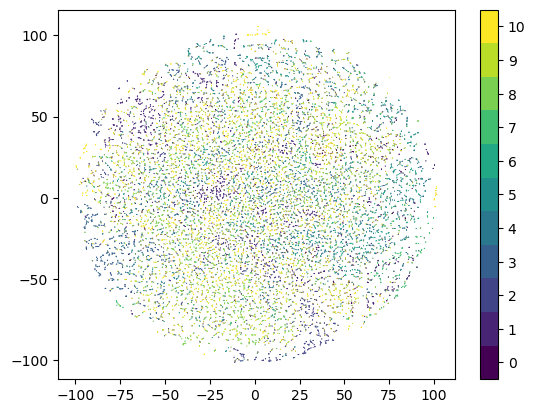

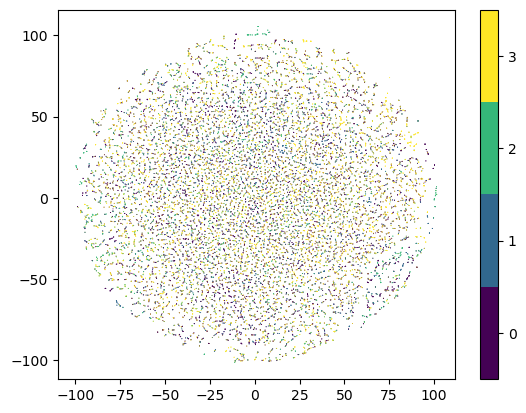

In [13]:
subjects = np.unique(subject_data_names)
subject_data = np.empty(subject_data_names.shape, dtype=int)
for s, sub in enumerate(subjects):
    subject_data[subject_data_names==sub] = s
print(f"designmtx.shape = {designmtx.shape}")
print(f"condition_data.shape = {condition_data.shape}")
print(f"subject_data.shape = {subject_data.shape}")
    
conditions = np.unique(condition_data)
markers = ['v', '^', '<', '>', 's', '*', '+' , 'x', 'D', '.']
colours = ['b','g','r','y','k']
cmap = plt.cm.rainbow
norm = colors.BoundaryNorm(np.arange(np.min(subject_data)-0.5,np.max(subject_data)+0.5), cmap.N)

plt.scatter(
    design2d[:,0], design2d[:,1], c=subject_data, norm=norm, s=0.5, edgecolor='none')
plt.colorbar(
    ticks=np.arange(subjects.size))


plt.figure()
cmap = plt.cm.rainbow
norm = colors.BoundaryNorm(np.arange(np.min(condition_data)-0.5,np.max(condition_data)+0.5), cmap.N)

plt.scatter(
    design2d[:,0], design2d[:,1], c=condition_data, norm=norm, s=0.5, edgecolor='none')
plt.colorbar(
    ticks=np.arange(conditions.size))
# for s,subject in enumerate(subjects):
#     marker = s
#     for c, condition in enumerate(conditions):
#         _filter = (condition_data==condition) &(subject_data==subject)
#         #print(f"condition = {condition}")
#         #print(f"np.sum(_filter) = {np.sum(_filter)}")
#         plt.plot(design2d[_filter,0], design2d[_filter,1], ls='None', marker=markers[s], color=colours[c], markeredgewidth=0.1)
        

## Classification

In [17]:
import pandas as pd

from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.model_selection import GroupKFold

models = {
    "Random Forest": RandomForestClassifier(
        min_samples_leaf=5, random_state=0
    ),
    "Gradient Boosting": GradientBoostingClassifier(
        max_leaf_nodes=15, random_state=0
    ),
    "MLP":  MLPClassifier(max_iter=100)
}
param_grids = {
    "Random Forest": {"n_estimators": [10, 20, 50, 100]},
    "Gradient Boosting": {"n_estimators": [10, 20, 50, 100]},
    "MLP": {
        'hidden_layer_sizes': [(10,),(20,),(50,),(100,)],
        'activation': ['relu'],
        'solver': ['sgd', 'adam'],
        'alpha': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05],
        'learning_rate': ['constant','adaptive'],
    }
}

# determine the columns to use
features_to_use = set(
    ['Mean', 'SD', 'MAD', 'Max', 'Min',# 'SMA',
      'Energy', 'IQR', # 'Entropy',
     'arCoeff', 'Correlation', 'MaxFreqInd', 'MeanFreq', 'FreqSkewness',
    'FreqKurtosis' # , 'EnergyBands'
    ])
columns_to_use = [ col for col in featured_df.columns if re.sub(res_digit, '', col) in features_to_use ]
print(f"columns_to_use = {columns_to_use}")

designmtx = featured_df[columns_to_use].to_numpy()

condition_data = featured_df['condition'].values.astype(int)


columns_to_use = ['Mean0', 'Mean1', 'Mean2', 'Mean3', 'Mean4', 'SD0', 'SD1', 'SD2', 'SD3', 'SD4', 'MAD0', 'MAD1', 'MAD2', 'MAD3', 'MAD4', 'Max0', 'Max1', 'Max2', 'Max3', 'Max4', 'Min0', 'Min1', 'Min2', 'Min3', 'Min4', 'Energy0', 'Energy1', 'Energy2', 'Energy3', 'Energy4', 'IQR0', 'IQR1', 'IQR2', 'IQR3', 'IQR4', 'Correlation0', 'Correlation1', 'Correlation2', 'Correlation3', 'Correlation4', 'Correlation5', 'Correlation6', 'Correlation7', 'Correlation8', 'Correlation9', 'arCoeff0', 'arCoeff1', 'arCoeff2', 'arCoeff3', 'arCoeff4', 'arCoeff5', 'arCoeff6', 'arCoeff7', 'arCoeff8', 'arCoeff9', 'arCoeff10', 'arCoeff11', 'arCoeff12', 'arCoeff13', 'arCoeff14', 'arCoeff15', 'arCoeff16', 'arCoeff17', 'arCoeff18', 'arCoeff19', 'MaxFreqInd0', 'MaxFreqInd1', 'MaxFreqInd2', 'MaxFreqInd3', 'MaxFreqInd4', 'MeanFreq0', 'MeanFreq1', 'MeanFreq2', 'MeanFreq3', 'MeanFreq4', 'FreqSkewness0', 'FreqSkewness1', 'FreqSkewness2', 'FreqSkewness3', 'FreqSkewness4', 'FreqKurtosis0', 'FreqKurtosis1', 'FreqKurtosis2', '

## Hold one group out

In [18]:
# standard cross-validation
# Match all digits in the string and replace them with an empty string
# new_string = re.sub(pattern, '', string1)
subjects = np.unique(featured_df['part_ID'])
n_subjects = len(subjects)
groups = np.empty(len(featured_df), dtype=int)
for s, sub in enumerate(subjects):
    groups[featured_df['part_ID']==sub] = s
# cross validation splits    
group_kfold = GroupKFold(n_splits=n_subjects)


In [19]:
results_df = pd.DataFrame()
results = []
for name, model in models.items():
    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grids[name],
        return_train_score=True,
        cv=group_kfold,
    ).fit(X=designmtx, y=condition_data, groups=groups)
    result_df = pd.DataFrame(grid_search.cv_results_)
    #test_df['model'] = result['model']
    result_df.insert(0, 'model', name)
    result_df.insert(1, 'held out', 'subject')
    result_df.insert(2, 'feature set', str(features_to_use))
    display(result_df)
    results_df = pd.concat((results_df, result_df))
    #result = {"model": name, "cv_results": pd.DataFrame(grid_search.cv_results_)}
    #results.append(result)

,model,held out,feature set,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,params,split0_test_score,...,split4_train_score,split5_train_score,split6_train_score,split7_train_score,split8_train_score,split9_train_score,split10_train_score,split11_train_score,mean_train_score,std_train_score
0,Random Forest,subject,"{'Min', 'Energy', 'MeanFreq', 'IQR', 'arCoeff'...",0.878352,0.027888,0.003233,0.000415,10,{'n_estimators': 10},0.266507,...,0.964114,0.964706,0.969512,0.967992,0.964394,0.965878,0.965555,0.968225,0.965971,0.001712
1,Random Forest,subject,"{'Min', 'Energy', 'MeanFreq', 'IQR', 'arCoeff'...",1.804766,0.065974,0.005504,0.000771,20,{'n_estimators': 20},0.273709,...,0.979550,0.981597,0.980593,0.982109,0.981552,0.980326,0.982197,0.982521,0.981154,0.000878
2,Random Forest,subject,"{'Min', 'Energy', 'MeanFreq', 'IQR', 'arCoeff'...",4.647198,0.199652,0.013108,0.002702,50,{'n_estimators': 50},0.281513,...,0.987730,0.988432,0.989182,0.989331,0.988518,0.988196,0.990066,0.989013,0.988590,0.000701
3,Random Forest,subject,"{'Min', 'Energy', 'MeanFreq', 'IQR', 'arCoeff'...",9.671321,0.739652,0.024006,0.003322,100,{'n_estimators': 100},0.280312,...,0.989115,0.991193,0.989837,0.990111,0.990969,0.990582,0.992066,0.991385,0.990724,0.000733


,model,held out,feature set,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,params,split0_test_score,...,split4_train_score,split5_train_score,split6_train_score,split7_train_score,split8_train_score,split9_train_score,split10_train_score,split11_train_score,mean_train_score,std_train_score
0,Gradient Boosting,subject,"{'Min', 'Energy', 'MeanFreq', 'IQR', 'arCoeff'...",17.824586,0.337792,0.001995,0.000280,10,{'n_estimators': 10},0.207083,...,0.534732,0.534933,0.547994,0.543621,0.542798,0.542927,0.530478,0.540046,0.541370,0.009937
1,Gradient Boosting,subject,"{'Min', 'Energy', 'MeanFreq', 'IQR', 'arCoeff'...",35.392766,1.142503,0.002768,0.000397,20,{'n_estimators': 20},0.222689,...,0.603602,0.590273,0.612969,0.602628,0.593369,0.613688,0.603238,0.602160,0.603674,0.009902
2,Gradient Boosting,subject,"{'Min', 'Energy', 'MeanFreq', 'IQR', 'arCoeff'...",89.295195,4.229865,0.005208,0.000767,50,{'n_estimators': 50},0.231092,...,0.702685,0.686362,0.705022,0.706786,0.689737,0.699929,0.701477,0.697547,0.698677,0.009757
3,Gradient Boosting,subject,"{'Min', 'Energy', 'MeanFreq', 'IQR', 'arCoeff'...",181.665822,3.585675,0.009846,0.002475,100,{'n_estimators': 100},0.251501,...,0.788377,0.771607,0.785864,0.789734,0.776559,0.778172,0.783332,0.778638,0.780778,0.008160


/usr/lib/python3/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/lib/python3/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/lib/python3/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/lib/python3/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/lib/python3/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Opti

/usr/lib/python3/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/lib/python3/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/lib/python3/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/lib/python3/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/lib/python3/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Opti

/usr/lib/python3/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/lib/python3/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/lib/python3/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/lib/python3/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/lib/python3/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Opti

/usr/lib/python3/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/lib/python3/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/lib/python3/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/lib/python3/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/lib/python3/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Opti

,model,held out,feature set,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_activation,param_alpha,param_hidden_layer_sizes,...,split4_train_score,split5_train_score,split6_train_score,split7_train_score,split8_train_score,split9_train_score,split10_train_score,split11_train_score,mean_train_score,std_train_score
0,MLP,subject,"{'Min', 'Energy', 'MeanFreq', 'IQR', 'arCoeff'...",0.902444,0.067155,0.001728,0.000242,relu,0.0001,"(10,)",...,0.201662,0.204601,0.213480,0.210461,0.215249,0.215249,0.215249,0.208690,0.208205,0.005301
1,MLP,subject,"{'Min', 'Energy', 'MeanFreq', 'IQR', 'arCoeff'...",3.137547,0.854248,0.001958,0.000404,relu,0.0001,"(10,)",...,0.264859,0.279593,0.213874,0.224709,0.215636,0.216087,0.217377,0.268306,0.246673,0.025700
2,MLP,subject,"{'Min', 'Energy', 'MeanFreq', 'IQR', 'arCoeff'...",2.684147,0.099669,0.001792,0.000202,relu,0.0001,"(10,)",...,0.201662,0.204601,0.213480,0.210461,0.215249,0.215249,0.215249,0.208752,0.208310,0.005196
3,MLP,subject,"{'Min', 'Energy', 'MeanFreq', 'IQR', 'arCoeff'...",2.720511,1.014824,0.001923,0.000307,relu,0.0001,"(10,)",...,0.267300,0.211830,0.283307,0.210917,0.239309,0.284655,0.215636,0.208315,0.243284,0.036235
4,MLP,subject,"{'Min', 'Energy', 'MeanFreq', 'IQR', 'arCoeff'...",2.262198,0.173120,0.002126,0.000265,relu,0.0001,"(20,)",...,0.201662,0.204601,0.213480,0.210461,0.215313,0.215249,0.215249,0.208752,0.208154,0.005370
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,MLP,subject,"{'Min', 'Energy', 'MeanFreq', 'IQR', 'arCoeff'...",7.068870,1.437706,0.002646,0.000426,relu,0.05,"(50,)",...,0.321657,0.235360,0.281537,0.280788,0.279752,0.301168,0.207379,0.229852,0.271346,0.034374
92,MLP,subject,"{'Min', 'Energy', 'MeanFreq', 'IQR', 'arCoeff'...",3.012101,0.527593,0.003294,0.000508,relu,0.05,"(100,)",...,0.200541,0.204666,0.213480,0.210461,0.215249,0.215249,0.215249,0.208378,0.208251,0.005259
93,MLP,subject,"{'Min', 'Energy', 'MeanFreq', 'IQR', 'arCoeff'...",8.229035,2.249828,0.003388,0.000507,relu,0.05,"(100,)",...,0.234118,0.255143,0.275964,0.311105,0.233632,0.280978,0.245630,0.299894,0.262453,0.027812
94,MLP,subject,"{'Min', 'Energy', 'MeanFreq', 'IQR', 'arCoeff'...",10.277087,0.514650,0.003371,0.000524,relu,0.05,"(100,)",...,0.201662,0.204601,0.213480,0.210461,0.215249,0.215249,0.215249,0.208752,0.208299,0.005210


In [31]:
from importlib import reload
import predicament.evaluation.results
reload(predicament.evaluation.results)
from predicament.evaluation.results import test
from predicament.evaluation.results import save_results_df_to_file
results_df

,model,held out,feature set,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,params,split0_test_score,...,split9_train_score,split10_train_score,split11_train_score,mean_train_score,std_train_score,param_activation,param_alpha,param_hidden_layer_sizes,param_learning_rate,param_solver
0,Random Forest,subject,"{'Min', 'Energy', 'MeanFreq', 'IQR', 'arCoeff'...",0.878352,0.027888,0.003233,0.000415,10,{'n_estimators': 10},0.266507,...,0.965878,0.965555,0.968225,0.965971,0.001712,NaN,NaN,NaN,NaN,NaN
1,Random Forest,subject,"{'Min', 'Energy', 'MeanFreq', 'IQR', 'arCoeff'...",1.804766,0.065974,0.005504,0.000771,20,{'n_estimators': 20},0.273709,...,0.980326,0.982197,0.982521,0.981154,0.000878,NaN,NaN,NaN,NaN,NaN
2,Random Forest,subject,"{'Min', 'Energy', 'MeanFreq', 'IQR', 'arCoeff'...",4.647198,0.199652,0.013108,0.002702,50,{'n_estimators': 50},0.281513,...,0.988196,0.990066,0.989013,0.988590,0.000701,NaN,NaN,NaN,NaN,NaN
3,Random Forest,subject,"{'Min', 'Energy', 'MeanFreq', 'IQR', 'arCoeff'...",9.671321,0.739652,0.024006,0.003322,100,{'n_estimators': 100},0.280312,...,0.990582,0.992066,0.991385,0.990724,0.000733,NaN,NaN,NaN,NaN,NaN
0,Gradient Boosting,subject,"{'Min', 'Energy', 'MeanFreq', 'IQR', 'arCoeff'...",17.824586,0.337792,0.001995,0.000280,10,{'n_estimators': 10},0.207083,...,0.542927,0.530478,0.540046,0.541370,0.009937,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,MLP,subject,"{'Min', 'Energy', 'MeanFreq', 'IQR', 'arCoeff'...",7.068870,1.437706,0.002646,0.000426,NaN,"{'activation': 'relu', 'alpha': 0.05, 'hidden_...",0.226891,...,0.301168,0.207379,0.229852,0.271346,0.034374,relu,0.05,"(50,)",adaptive,adam
92,MLP,subject,"{'Min', 'Energy', 'MeanFreq', 'IQR', 'arCoeff'...",3.012101,0.527593,0.003294,0.000508,NaN,"{'activation': 'relu', 'alpha': 0.05, 'hidden_...",0.169868,...,0.215249,0.215249,0.208378,0.208251,0.005259,relu,0.05,"(100,)",constant,sgd
93,MLP,subject,"{'Min', 'Energy', 'MeanFreq', 'IQR', 'arCoeff'...",8.229035,2.249828,0.003388,0.000507,NaN,"{'activation': 'relu', 'alpha': 0.05, 'hidden_...",0.186675,...,0.280978,0.245630,0.299894,0.262453,0.027812,relu,0.05,"(100,)",constant,adam
94,MLP,subject,"{'Min', 'Energy', 'MeanFreq', 'IQR', 'arCoeff'...",10.277087,0.514650,0.003371,0.000524,NaN,"{'activation': 'relu', 'alpha': 0.05, 'hidden_...",0.181873,...,0.215249,0.215249,0.208752,0.208299,0.005210,relu,0.05,"(100,)",adaptive,sgd


In [32]:
save_results_df_to_file(results_df, 'balanced_eeg')

saving to ../data/results/balanced_eeg_2023-12-12T08:43:49.csv


In [33]:
output_model_best_from_results(results_df)

Gradient Boosting: max_test_score= 0.22389534372491024, max_std_test_score= 0.06334182766052263
best params: {'n_estimators': 100}

MLP: max_test_score= 0.2656577634163771, max_std_test_score= 0.10001973114790763
best params: {'activation': 'relu', 'alpha': 0.001, 'hidden_layer_sizes': (20,), 'learning_rate': 'constant', 'solver': 'adam'}

Random Forest: max_test_score= 0.21415626535025437, max_std_test_score= 0.07623024243583791
best params: {'n_estimators': 100}



In [34]:
results_df

,model,held out,feature set,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,params,split0_test_score,...,split9_train_score,split10_train_score,split11_train_score,mean_train_score,std_train_score,param_activation,param_alpha,param_hidden_layer_sizes,param_learning_rate,param_solver
0,Random Forest,subject,"{'Min', 'Energy', 'MeanFreq', 'IQR', 'arCoeff'...",0.878352,0.027888,0.003233,0.000415,10,{'n_estimators': 10},0.266507,...,0.965878,0.965555,0.968225,0.965971,0.001712,NaN,NaN,NaN,NaN,NaN
1,Random Forest,subject,"{'Min', 'Energy', 'MeanFreq', 'IQR', 'arCoeff'...",1.804766,0.065974,0.005504,0.000771,20,{'n_estimators': 20},0.273709,...,0.980326,0.982197,0.982521,0.981154,0.000878,NaN,NaN,NaN,NaN,NaN
2,Random Forest,subject,"{'Min', 'Energy', 'MeanFreq', 'IQR', 'arCoeff'...",4.647198,0.199652,0.013108,0.002702,50,{'n_estimators': 50},0.281513,...,0.988196,0.990066,0.989013,0.988590,0.000701,NaN,NaN,NaN,NaN,NaN
3,Random Forest,subject,"{'Min', 'Energy', 'MeanFreq', 'IQR', 'arCoeff'...",9.671321,0.739652,0.024006,0.003322,100,{'n_estimators': 100},0.280312,...,0.990582,0.992066,0.991385,0.990724,0.000733,NaN,NaN,NaN,NaN,NaN
0,Gradient Boosting,subject,"{'Min', 'Energy', 'MeanFreq', 'IQR', 'arCoeff'...",17.824586,0.337792,0.001995,0.000280,10,{'n_estimators': 10},0.207083,...,0.542927,0.530478,0.540046,0.541370,0.009937,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,MLP,subject,"{'Min', 'Energy', 'MeanFreq', 'IQR', 'arCoeff'...",7.068870,1.437706,0.002646,0.000426,NaN,"{'activation': 'relu', 'alpha': 0.05, 'hidden_...",0.226891,...,0.301168,0.207379,0.229852,0.271346,0.034374,relu,0.05,"(50,)",adaptive,adam
92,MLP,subject,"{'Min', 'Energy', 'MeanFreq', 'IQR', 'arCoeff'...",3.012101,0.527593,0.003294,0.000508,NaN,"{'activation': 'relu', 'alpha': 0.05, 'hidden_...",0.169868,...,0.215249,0.215249,0.208378,0.208251,0.005259,relu,0.05,"(100,)",constant,sgd
93,MLP,subject,"{'Min', 'Energy', 'MeanFreq', 'IQR', 'arCoeff'...",8.229035,2.249828,0.003388,0.000507,NaN,"{'activation': 'relu', 'alpha': 0.05, 'hidden_...",0.186675,...,0.280978,0.245630,0.299894,0.262453,0.027812,relu,0.05,"(100,)",constant,adam
94,MLP,subject,"{'Min', 'Energy', 'MeanFreq', 'IQR', 'arCoeff'...",10.277087,0.514650,0.003371,0.000524,NaN,"{'activation': 'relu', 'alpha': 0.05, 'hidden_...",0.181873,...,0.215249,0.215249,0.208752,0.208299,0.005210,relu,0.05,"(100,)",adaptive,sgd


## Random Search

In [36]:
from sklearn.model_selection import RandomizedSearchCV 
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]# Create the random grid
random_grid = {
    'n_estimators': n_estimators,
    'max_features': max_features,
    'max_depth': max_depth,
    'min_samples_split': min_samples_split,
    'min_samples_leaf': min_samples_leaf,
    'bootstrap': bootstrap}

In [37]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(
    estimator = rf,
    param_distributions = random_grid,
    n_iter = 100,
    cv=group_kfold,
    verbose=2,
    random_state=42,
    n_jobs = -1)


# Fit the random search model
rf_random.fit(X=designmtx, y=condition_data, groups=groups)
random_result_df = pd.DataFrame(rf_random.cv_results_)
save_results_df_to_file(random_result_df, 'random_search_random_forest')

Fitting 12 folds for each of 100 candidates, totalling 1200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed: 29.7min


[CV] n_estimators=400, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=30, bootstrap=True 
[CV]  n_estimators=400, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=30, bootstrap=True, total=  56.0s
[CV] n_estimators=400, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=30, bootstrap=True 
[CV]  n_estimators=400, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=30, bootstrap=True, total= 1.1min
[CV] n_estimators=400, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=30, bootstrap=True 
[CV]  n_estimators=400, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=30, bootstrap=True, total= 1.3min
[CV] n_estimators=2000, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=10, bootstrap=True 
[CV]  n_estimators=2000, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=10, bootstrap=True, total= 4.3min
[CV] n_estimators=2000, min_sample

/usr/lib/python3/dist-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] n_estimators=400, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=30, bootstrap=True 
[CV]  n_estimators=400, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=30, bootstrap=True, total=  58.7s
[CV] n_estimators=400, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=30, bootstrap=True 
[CV]  n_estimators=400, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=30, bootstrap=True, total= 1.1min
[CV] n_estimators=400, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=30, bootstrap=True 
[CV]  n_estimators=400, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=30, bootstrap=True, total= 1.3min
[CV] n_estimators=2000, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=10, bootstrap=True 
[CV]  n_estimators=2000, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=10, bootstrap=True, total= 4.4min
[CV] n_estimators=2000, min_sample

[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 226.9min


[CV] n_estimators=2000, min_samples_split=2, min_samples_leaf=4, max_features=auto, max_depth=30, bootstrap=False 
[CV]  n_estimators=2000, min_samples_split=2, min_samples_leaf=4, max_features=auto, max_depth=30, bootstrap=False, total=12.6min
[CV] n_estimators=2000, min_samples_split=2, min_samples_leaf=4, max_features=auto, max_depth=30, bootstrap=False 
[CV]  n_estimators=2000, min_samples_split=2, min_samples_leaf=4, max_features=auto, max_depth=30, bootstrap=False, total=12.5min
[CV] n_estimators=1600, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=10, bootstrap=True 
[CV]  n_estimators=1600, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=10, bootstrap=True, total= 4.6min
[CV] n_estimators=1600, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=10, bootstrap=True 
[CV]  n_estimators=1600, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=10, bootstrap=True, total= 4.8min
[CV] n_estimators=1600, 

[CV] n_estimators=2000, min_samples_split=2, min_samples_leaf=4, max_features=auto, max_depth=30, bootstrap=False 
[CV]  n_estimators=2000, min_samples_split=2, min_samples_leaf=4, max_features=auto, max_depth=30, bootstrap=False, total=12.5min
[CV] n_estimators=2000, min_samples_split=2, min_samples_leaf=4, max_features=auto, max_depth=30, bootstrap=False 
[CV]  n_estimators=2000, min_samples_split=2, min_samples_leaf=4, max_features=auto, max_depth=30, bootstrap=False, total=12.9min
[CV] n_estimators=1600, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=10, bootstrap=True 
[CV]  n_estimators=1600, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=10, bootstrap=True, total= 4.8min
[CV] n_estimators=1600, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=10, bootstrap=True 
[CV]  n_estimators=1600, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=10, bootstrap=True, total= 4.9min
[CV] n_estimators=1600, 

[CV]  n_estimators=800, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=30, bootstrap=False, total= 3.5min
[CV] n_estimators=800, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=30, bootstrap=False 
[CV]  n_estimators=800, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=30, bootstrap=False, total= 3.5min
[CV] n_estimators=800, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=30, bootstrap=False 
[CV]  n_estimators=800, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=30, bootstrap=False, total= 3.6min
[CV] n_estimators=1800, min_samples_split=2, min_samples_leaf=4, max_features=auto, max_depth=50, bootstrap=False 
[CV]  n_estimators=1800, min_samples_split=2, min_samples_leaf=4, max_features=auto, max_depth=50, bootstrap=False, total= 7.6min
[CV] n_estimators=1800, min_samples_split=2, min_samples_leaf=4, max_features=auto, max_depth=50, bootstrap=False 
[CV]  n_estimators=1

[CV]  n_estimators=800, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=30, bootstrap=False, total= 3.6min
[CV] n_estimators=1800, min_samples_split=2, min_samples_leaf=4, max_features=auto, max_depth=50, bootstrap=False 
[CV]  n_estimators=1800, min_samples_split=2, min_samples_leaf=4, max_features=auto, max_depth=50, bootstrap=False, total= 7.3min
[CV] n_estimators=1800, min_samples_split=2, min_samples_leaf=4, max_features=auto, max_depth=50, bootstrap=False 
[CV]  n_estimators=1800, min_samples_split=2, min_samples_leaf=4, max_features=auto, max_depth=50, bootstrap=False, total= 7.7min
[CV] n_estimators=1800, min_samples_split=2, min_samples_leaf=4, max_features=auto, max_depth=50, bootstrap=False 
[CV]  n_estimators=1800, min_samples_split=2, min_samples_leaf=4, max_features=auto, max_depth=50, bootstrap=False, total= 8.2min
[CV] n_estimators=600, min_samples_split=5, min_samples_leaf=2, max_features=auto, max_depth=70, bootstrap=False 
[CV]  n_estimators=60

[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed: 574.2min


KeyboardInterrupt: 

In [ ]:
# # focus on MLP model
# name = "MLP"  
# mlp_param_grid = dict(
#     hidden_layer_sizes=[(10*i,) for i in range(1,21)],
# #     activation=['tanh', 'relu'],
# #     solver=['sgd', 'adam'],
#     alpha=np.logspace(-5,-1,13),
# #     learning_rate=['constant','adaptive'],
#     #learning_rate_init=np.logspace(-5,-1,13),
#     max_iter=[50, 100, 150, 200]
#     )

# for param in mlp_param_grid.keys():
#     these_static_params = { k:v for k, v in mlp_best_params.items() if k != param }
#     model = MLPClassifier(**these_static_params)
#     this_param_grid = { k:v for k,v in mlp_param_grid.items() if k == param }
#     grid_search = GridSearchCV(
#         estimator=model,
#         param_grid=this_param_grid,
#         return_train_score=True,
#         cv=group_kfold,
#     ).fit(X=designmtx, y=condition_data, groups=groups)
#     result_df = pd.DataFrame(grid_search.cv_results_)
#     #test_df['model'] = result['model']
#     result_df.insert(0, 'model', name)
#     result_df.insert(1, 'held out', 'subject')
#     result_df.insert(2, 'feature set', str(features_to_use))
#     display(result_df)
#     results_df = pd.concat((results_df, result_df))


In [38]:
# Bayesian optimisation

from skopt import BayesSearchCV
# parameter ranges are specified by one of below
from skopt.space import Real, Categorical, Integer

# from sklearn.datasets import load_iris
# from sklearn.svm import SVC
# from sklearn.model_selection import train_test_split

# X, y = load_iris(True)
# X_train, X_test, y_train, y_test = train_test_split(X, y,
#      train_size=0.75,
#     random_state=0)

# estimator = SVC()
# search_spaces =      {
#          'C': Real(1e-6, 1e+6, prior='log-uniform'),
#          'gamma': Real(1e-6, 1e+1, prior='log-uniform'),
#          'degree': Integer(1,8),
#          'kernel': Categorical(['linear', 'poly', 'rbf']),
#      }
estimator = MLPClassifier(max_iter=100)
#     "MLP": {
#         'hidden_layer_sizes': [(10,),(20,),(50,),(100,)],
#         'activation': ['relu'],
#         'solver': ['sgd', 'adam'],
#         'alpha': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05],
#         'learning_rate': ['constant','adaptive'],
#     }
search_spaces =      {
        'hidden_layer_sizes': Categorical([ (n,) for n in range(10,200,10)]),
        'activation': Categorical(['tanh', 'relu']),
        'solver': Categorical(['sgd', 'adam']),
        'alpha': Real(1e-6, 1e+1, prior='log-uniform'),
        'learning_rate': Categorical(['constant','adaptive']),
     }

# log-uniform: understand as search over p = exp(x) by varying x
param_search = BayesSearchCV(
    estimator, search_spaces,
    cv=group_kfold, verbose=2, random_state=42, n_iter=50)

# executes bayesian optimization
_ = param_search.fit(X=designmtx, y=condition_data, groups=groups)
result_df = pd.DataFrame(param_search.cv_results_)
result_df.insert(0, 'model', name)
result_df.insert(1, 'held out', 'subject')
result_df.insert(2, 'feature set', str(features_to_use))
display(result_df)
# results_df = pd.concat((results_df, result_df))

save_results_df_to_file(result_df, 'bayes_search')

# # model can be saved, used for predictions or scoring
# print(opt.score(X_test, y_test))

Fitting 12 folds for each of 1 candidates, totalling 12 fits
[CV] activation=relu, alpha=0.1241881627783703, hidden_layer_sizes=180, learning_rate=adaptive, solver=sgd 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/usr/lib/python3/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   15.7s remaining:    0.0s


[CV]  activation=relu, alpha=0.1241881627783703, hidden_layer_sizes=180, learning_rate=adaptive, solver=sgd, total=  15.7s
[CV] activation=relu, alpha=0.1241881627783703, hidden_layer_sizes=180, learning_rate=adaptive, solver=sgd 


/usr/lib/python3/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=relu, alpha=0.1241881627783703, hidden_layer_sizes=180, learning_rate=adaptive, solver=sgd, total=  17.4s
[CV] activation=relu, alpha=0.1241881627783703, hidden_layer_sizes=180, learning_rate=adaptive, solver=sgd 


/usr/lib/python3/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=relu, alpha=0.1241881627783703, hidden_layer_sizes=180, learning_rate=adaptive, solver=sgd, total=  16.6s
[CV] activation=relu, alpha=0.1241881627783703, hidden_layer_sizes=180, learning_rate=adaptive, solver=sgd 


/usr/lib/python3/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=relu, alpha=0.1241881627783703, hidden_layer_sizes=180, learning_rate=adaptive, solver=sgd, total=  16.9s
[CV] activation=relu, alpha=0.1241881627783703, hidden_layer_sizes=180, learning_rate=adaptive, solver=sgd 


/usr/lib/python3/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=relu, alpha=0.1241881627783703, hidden_layer_sizes=180, learning_rate=adaptive, solver=sgd, total=  17.2s
[CV] activation=relu, alpha=0.1241881627783703, hidden_layer_sizes=180, learning_rate=adaptive, solver=sgd 


/usr/lib/python3/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=relu, alpha=0.1241881627783703, hidden_layer_sizes=180, learning_rate=adaptive, solver=sgd, total=  17.4s
[CV] activation=relu, alpha=0.1241881627783703, hidden_layer_sizes=180, learning_rate=adaptive, solver=sgd 


/usr/lib/python3/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=relu, alpha=0.1241881627783703, hidden_layer_sizes=180, learning_rate=adaptive, solver=sgd, total=  17.8s
[CV] activation=relu, alpha=0.1241881627783703, hidden_layer_sizes=180, learning_rate=adaptive, solver=sgd 


/usr/lib/python3/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=relu, alpha=0.1241881627783703, hidden_layer_sizes=180, learning_rate=adaptive, solver=sgd, total=  18.9s
[CV] activation=relu, alpha=0.1241881627783703, hidden_layer_sizes=180, learning_rate=adaptive, solver=sgd 


/usr/lib/python3/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=relu, alpha=0.1241881627783703, hidden_layer_sizes=180, learning_rate=adaptive, solver=sgd, total=  17.9s
[CV] activation=relu, alpha=0.1241881627783703, hidden_layer_sizes=180, learning_rate=adaptive, solver=sgd 


/usr/lib/python3/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=relu, alpha=0.1241881627783703, hidden_layer_sizes=180, learning_rate=adaptive, solver=sgd, total=  18.0s
[CV] activation=relu, alpha=0.1241881627783703, hidden_layer_sizes=180, learning_rate=adaptive, solver=sgd 


/usr/lib/python3/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=relu, alpha=0.1241881627783703, hidden_layer_sizes=180, learning_rate=adaptive, solver=sgd, total=  18.4s
[CV] activation=relu, alpha=0.1241881627783703, hidden_layer_sizes=180, learning_rate=adaptive, solver=sgd 


/usr/lib/python3/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:  3.5min finished


[CV]  activation=relu, alpha=0.1241881627783703, hidden_layer_sizes=180, learning_rate=adaptive, solver=sgd, total=  18.8s


ValueError: Not all points are within the bounds of the space.

In [49]:
dict(result_df[result_df['mean_test_score'] == result_df['mean_test_score'].max()].loc[37])

{'model': 'MLP',
 'held out': 'subject',
 'feature set': "{'Min', 'Energy', 'MeanFreq', 'IQR', 'arCoeff', 'MAD', 'FreqKurtosis', 'MaxFreqInd', 'Max', 'SD', 'FreqSkewness', 'Mean', 'Correlation'}",
 'mean_fit_time': 8.388911843299866,
 'std_fit_time': 1.5732406828250838,
 'mean_score_time': 0.002245604991912842,
 'std_score_time': 0.0002622555805428552,
 'param_activation': 'relu',
 'param_alpha': 0.001,
 'param_hidden_layer_sizes': (20,),
 'param_learning_rate': 'constant',
 'param_solver': 'adam',
 'params': {'activation': 'relu',
  'alpha': 0.001,
  'hidden_layer_sizes': (20,),
  'learning_rate': 'constant',
  'solver': 'adam'},
 'split0_test_score': 0.2418967587034814,
 'split1_test_score': 0.2689075630252101,
 'split2_test_score': 0.2028811524609844,
 'split3_test_score': 0.19414385741565882,
 'split4_test_score': 0.2130406714009038,
 'split5_test_score': 0.20897521768251842,
 'split6_test_score': 0.2657967032967033,
 'split7_test_score': 0.23036649214659685,
 'split8_test_score': 

In [ ]:
# # balancing data
# ## first get the proposed new counts of each subject and condition
# def propose_balanced_subject_condition_counts(df):
#     subjects = np.unique(df['part_ID'])
#     n_subjects = subjects.size
#     conditions = np.unique(df['condition'])
#     n_conditions = conditions.size
# #     tot = len(df)
#     subject_condition_counts = np.zeros((subjects.size,conditions.size), dtype=int)

#     for s, part_ID in enumerate(subjects): 
#         subj_df = df[df['part_ID'] == part_ID]
#         for c, cond in enumerate(conditions):
#             count = len(subj_df[subj_df['condition'] == cond])
#     #         print(f"count = {count}")
#     #         print(f"{s}-{c} : {count}/{tot} = {count/tot}")
#             subject_condition_counts[s,c] = count

#     # print(f"subject_condition_counts = {subject_condition_counts}")
#     condition_counts = np.sum(subject_condition_counts, axis=0)
#     # print(f"condition_counts = {condition_counts}")
#     desired_condition_count = np.min(condition_counts)
#     # print(f"desired_condition_count = {desired_condition_count}")
#     proposed_subject_condition_counts = np.ones(subject_condition_counts.shape)*desired_condition_count//len(subjects)
#     proposed_subject_condition_counts = np.minimum(subject_condition_counts, proposed_subject_condition_counts)
#     to_allocate = desired_condition_count - np.sum(proposed_subject_condition_counts, axis=0)
#     while np.any(to_allocate >= n_subjects):
#         proposed_subject_condition_counts += (to_allocate//n_subjects).reshape((1,-1))
#         proposed_subject_condition_counts = np.minimum(subject_condition_counts,proposed_subject_condition_counts)
#         to_allocate = desired_condition_count - np.sum(proposed_subject_condition_counts, axis=0)
#     # print(f"proposed_subject_condition_counts = {proposed_subject_condition_counts}")
#     # print(f"to_allocate = {to_allocate}")
#     proposed_condition_counts = np.sum(proposed_subject_condition_counts, axis=0)
#     # print(f"proposed_condition_counts = {proposed_condition_counts}")
#     proposed_class_balance = proposed_condition_counts/np.sum(proposed_condition_counts)
#     # print(f"proposed_class_balance = {proposed_class_balance}")
#     # print("add one to cells with the capacity...")
#     while np.any(to_allocate > 0):
#         proposed_subject_condition_counts[(subject_condition_counts > proposed_subject_condition_counts) & (to_allocate.reshape((1,-1)) > 0)] += 1
#         #print(f"proposed_subject_condition_counts = {proposed_subject_condition_counts}")
#         to_allocate = desired_condition_count - np.sum(proposed_subject_condition_counts, axis=0)
#         #print(f"to_allocate = {to_allocate}")
#     return proposed_subject_condition_counts.astype(int)
    

# Balanced data 



In [ ]:
subjects = np.unique(balanced_featured_df['part_ID'])
n_subjects = len(subjects)
groups = np.empty(len(balanced_featured_df), dtype=int)
for s, sub in enumerate(subjects):
    groups[balanced_featured_df['part_ID']==sub] = s
    
features_to_use = set(
    ['Mean', 'SD', 'MAD', 'Max', 'Min',# 'SMA',
      'Energy', 'IQR', # 'Entropy',
     'arCoeff', 'Correlation', 'MaxFreqInd', 'MeanFreq', 'FreqSkewness',
    'FreqKurtosis' # , 'EnergyBands'
    ])
columns_to_use = [ col for col in balanced_featured_df.columns if re.sub(res_digit, '', col) in features_to_use ]
print(f"columns_to_use = {columns_to_use}")

In [ ]:
designmtx = balanced_featured_df[columns_to_use].values 
condition_data = balanced_featured_df['condition'].values.astype(int)

balanced_results_df = pd.DataFrame()
group_kfold = GroupKFold(n_splits=n_subjects)
results = []
for name, model in models.items():
    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grids[name],
        return_train_score=True,
        cv=group_kfold,
    ).fit(X=designmtx, y=condition_data, groups=groups)
    result_df = pd.DataFrame(grid_search.cv_results_)
    #test_df['model'] = result['model']
    result_df.insert(0, 'model', name)
    result_df.insert(1, 'held out', 'subject')
    result_df.insert(2, 'feature set', str(features_to_use))
    display(result_df)
    balanced_results_df = pd.concat((balanced_results_df, result_df))
    #result = {"model": name, "cv_results": pd.DataFrame(grid_search.cv_results_)}
    #results.append(result)

In [ ]:
# def output_model_best_from_results(results_df):
#     for model in np.unique(results_df['model']):
#         model_max_test_score = results_df[results_df['model'] == model]['mean_test_score'].max()
#         model_max_std_test_score = results_df[(results_df['model'] == model) & (results_df['mean_test_score']==model_max_test_score)]['std_test_score'].to_numpy()[0]
#         print(f"{model}: max_test_score= {model_max_test_score}, max_std_test_score= {model_max_std_test_score}")
#         d = results_df[results_df['mean_test_score'] == model_max_test_score]['params']
#         for k,v in d.items():
#             model_best_params = v
#             print(f"best params: {v}")
#         print()


In [ ]:
# def save_results_df_to_file(df, shortname, timestamp=True):
#     import datetime
#     nowstr = datetime.datetime.now().replace(microsecond=0).isoformat()
#     if timestamp:
#         name = shortname + '_' + nowstr
#     else:
#         name = shortname
#     fpath = f'../data/results/{name}.csv'
#     print(f"saving to {fpath}")
#     results_df.to_csv(fpath)
